In [13]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [3]:
file_path = r"C:\Users\19114\Downloads\individual+household+electric+power+consumption (1)\household_power_consumption.txt"

print(f"Loading data from: {file_path}")
data = pd.read_csv(file_path, 
                   sep=';', 
                   low_memory=False)

print("Data loaded successfully.")

Loading data from: C:\Users\19114\Downloads\individual+household+electric+power+consumption (1)\household_power_consumption.txt
Data loaded successfully.


In [5]:
print(data.head())

# Checking the data types and non-null counts
print("\nData Types and Null Counts (raw):")
data.info()

         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  

Data Types and Null Counts (raw):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (

In [7]:
#Combining Date Time
data['Datetime'] = data['Date'] + ' ' + data['Time']

#Converting to datetime object
data['Datetime'] = pd.to_datetime(data['Datetime'], dayfirst=True)

print("Setting Datetime as index...")
data = data.set_index('Datetime')
data = data.drop(columns=['Date', 'Time'])

print(data.head())

Setting Datetime as index...
                    Global_active_power Global_reactive_power  Voltage  \
Datetime                                                                 
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
Datetime                                                             
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15

In [9]:
cols_to_convert = data.columns

print("\nConverting measurement columns to numeric (float)...")
for col in cols_to_convert:
    data[col] = pd.to_numeric(data[col], errors='coerce')

#Checking for Missing Values
print("\nChecking for missing values (NaN) after conversion:")
print(data.isnull().sum())

#Naming the target column for clarity
data = data.rename(columns={'Global_active_power': 'Target_Active_Power'})



Converting measurement columns to numeric (float)...

Checking for missing values (NaN) after conversion:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [15]:
#Using Forward Fill
# Filling the NaN values with the previous non-null value in the column
data.fillna(method='ffill', inplace=True)

print(data.isnull().sum())


Target_Active_Power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [17]:
print("Creating time-based features from the Datetime Index....")

#Extracting Time Features ---
data['Hour'] = data.index.hour                # Hour of the day (0-23)
data['DayOfWeek'] = data.index.dayofweek      # Day of the week (Monday=0, Sunday=6)
data['Month'] = data.index.month              # Month of the year (1-12)
data['Year'] = data.index.year                # Year
data['WeekOfYear'] = data.index.isocalendar().week.astype(int) # Week number of the year
data['DayOfYear'] = data.index.dayofyear      # Day number of the year (1-366)

print("\nTime-based features created.")
print("Updated Head (showing new features):")
print(data[['Target_Active_Power', 'Hour', 'DayOfWeek', 'Month']].head())

Creating time-based features from the Datetime Index....

Time-based features created.
Updated Head (showing new features):
                     Target_Active_Power  Hour  DayOfWeek  Month
Datetime                                                        
2006-12-16 17:24:00                4.216    17          5     12
2006-12-16 17:25:00                5.360    17          5     12
2006-12-16 17:26:00                5.374    17          5     12
2006-12-16 17:27:00                5.388    17          5     12
2006-12-16 17:28:00                3.666    17          5     12


In [19]:
print("\nCreating Rolling Average Features...")

# Creating a rolling window of size 24 
# .shift(1) is crucial to prevent "data leakage" by only using data *before* the current timestamp.
# Using a 24-period (24-hour) rolling mean for the target.
data['Rolling_Mean_24h'] = data['Target_Active_Power'].rolling(window=24).mean().shift(1)

# Rolling features create NaN values at the start (the first 23 rows) that need imputation.
# using ffill again to fill these gaps.
data['Rolling_Mean_24h'].fillna(method='ffill', inplace=True)

print("Rolling mean feature created and gaps filled.")
print("Updated Head (showing new rolling feature):")
print(data[['Target_Active_Power', 'Rolling_Mean_24h']].head(10))


Creating Rolling Average Features...
Rolling mean feature created and gaps filled.
Updated Head (showing new rolling feature):
                     Target_Active_Power  Rolling_Mean_24h
Datetime                                                  
2006-12-16 17:24:00                4.216               NaN
2006-12-16 17:25:00                5.360               NaN
2006-12-16 17:26:00                5.374               NaN
2006-12-16 17:27:00                5.388               NaN
2006-12-16 17:28:00                3.666               NaN
2006-12-16 17:29:00                3.520               NaN
2006-12-16 17:30:00                3.702               NaN
2006-12-16 17:31:00                3.700               NaN
2006-12-16 17:32:00                3.668               NaN
2006-12-16 17:33:00                3.662               NaN


In [21]:
from sklearn.preprocessing import MinMaxScaler
from pandas.api.types import is_numeric_dtype # Helper to check data type

print("\nScaling all numerical features (Normalization)...")

scaler = MinMaxScaler()

# Scaling all numeric columns EXCEPT the new time-based integer columns (Hour, DayOfWeek, etc.) 
# and the Target_Active_Power (which we may or may not scale, but let's keep it separate for now)
features_to_scale = [col for col in data.columns if is_numeric_dtype(data[col]) and col not in ['Hour', 'DayOfWeek', 'Month', 'Year', 'WeekOfYear', 'DayOfYear', 'Target_Active_Power']]

# Fit and transform the selected features
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

print("Scaling complete.")
print("Updated Head (showing scaled values, now between 0 and 1):")
print(data[features_to_scale].head())


Scaling all numerical features (Normalization)...
Scaling complete.
Updated Head (showing scaled values, now between 0 and 1):
                     Global_reactive_power   Voltage  Global_intensity  \
Datetime                                                                 
2006-12-16 17:24:00               0.300719  0.376090          0.377593   
2006-12-16 17:25:00               0.313669  0.336995          0.473029   
2006-12-16 17:26:00               0.358273  0.326010          0.473029   
2006-12-16 17:27:00               0.361151  0.340549          0.473029   
2006-12-16 17:28:00               0.379856  0.403231          0.323651   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Datetime                                                              
2006-12-16 17:24:00             0.0          0.0125        0.548387   
2006-12-16 17:25:00             0.0          0.0125        0.516129   
2006-12-16 17:26:00             0.0          0.0250        0.548387  

In [23]:


print("Applying final Forward Fill to Rolling_Mean_24h...")

data['Rolling_Mean_24h'].ffill(inplace=True) 

print(data['Rolling_Mean_24h'].head(10))

print(data['Rolling_Mean_24h'].isnull().sum())

Applying final Forward Fill to Rolling_Mean_24h...
Datetime
2006-12-16 17:24:00   NaN
2006-12-16 17:25:00   NaN
2006-12-16 17:26:00   NaN
2006-12-16 17:27:00   NaN
2006-12-16 17:28:00   NaN
2006-12-16 17:29:00   NaN
2006-12-16 17:30:00   NaN
2006-12-16 17:31:00   NaN
2006-12-16 17:32:00   NaN
2006-12-16 17:33:00   NaN
Name: Rolling_Mean_24h, dtype: float64
24


In [27]:
data['Rolling_Mean_24h'].ffill(inplace=True) 
print(data['Rolling_Mean_24h'].isnull().sum())
print(data['Rolling_Mean_24h'].head(30))

24
Datetime
2006-12-16 17:24:00         NaN
2006-12-16 17:25:00         NaN
2006-12-16 17:26:00         NaN
2006-12-16 17:27:00         NaN
2006-12-16 17:28:00         NaN
2006-12-16 17:29:00         NaN
2006-12-16 17:30:00         NaN
2006-12-16 17:31:00         NaN
2006-12-16 17:32:00         NaN
2006-12-16 17:33:00         NaN
2006-12-16 17:34:00         NaN
2006-12-16 17:35:00         NaN
2006-12-16 17:36:00         NaN
2006-12-16 17:37:00         NaN
2006-12-16 17:38:00         NaN
2006-12-16 17:39:00         NaN
2006-12-16 17:40:00         NaN
2006-12-16 17:41:00         NaN
2006-12-16 17:42:00         NaN
2006-12-16 17:43:00         NaN
2006-12-16 17:44:00         NaN
2006-12-16 17:45:00         NaN
2006-12-16 17:46:00         NaN
2006-12-16 17:47:00         NaN
2006-12-16 17:48:00    0.558609
2006-12-16 17:49:00    0.559948
2006-12-16 17:50:00    0.548988
2006-12-16 17:51:00    0.537893
2006-12-16 17:52:00    0.526684
2006-12-16 17:53:00    0.524567
Name: Rolling_Mean_24h, dtyp

In [29]:
#Separating Features (X) and Target (y)
#Target variable is the Global Active Power
Y = data['Target_Active_Power']

# Features (X) are all other columns and dropping the target variable from the feature set
X = data.drop(columns=['Target_Active_Power']) 

print(f"Features (X) Shape: {X.shape}")
print(f"Target (Y) Shape: {Y.shape}")

Features (X) Shape: (2075259, 13)
Target (Y) Shape: (2075259,)


In [31]:
from sklearn.model_selection import train_test_split

print("\nSplitting data into 80% Train and 20% Test (maintaining time order)...")

# Calculating the index point for the 80% split
split_point = int(len(X) * 0.8)
#sequentially splitting data
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
Y_train = Y.iloc[:split_point]
Y_test = Y.iloc[split_point:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")


Splitting data into 80% Train and 20% Test (maintaining time order)...
X_train shape: (1660207, 13)
X_test shape: (415052, 13)
Y_train shape: (1660207,)
Y_test shape: (415052,)


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print("\n--- Training Linear Regression Baseline Model ---")

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred_lr = lr_model.predict(X_test)

# Model Evaluation
rmse_lr = np.sqrt(mean_squared_error(Y_test, Y_pred_lr)) # [cite: 43]
mae_lr = mean_absolute_error(Y_test, Y_pred_lr) # [cite: 44]
r2_lr = r2_score(Y_test, Y_pred_lr) # [cite: 45, 46]

print("\n--- Linear Regression Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.4f}")
print(f"R-Squared (R²): {r2_lr:.4f}")


--- Training Linear Regression Baseline Model ---


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [35]:
data['Rolling_Mean_24h'].ffill(inplace=True) 

features_for_check = data.drop(columns=['Target_Active_Power']).columns
print(data[features_for_check].isnull().sum().sum()) # Should be 0

24


In [41]:
data.ffill(inplace=True) 

data.bfill(inplace=True)

# Final check for any NaNs across all features
features_for_check = data.drop(columns=['Target_Active_Power']).columns
final_nan_count = data[features_for_check].isnull().sum().sum
print(final_nan_count)


<bound method Series.sum of Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Hour                     0
DayOfWeek                0
Month                    0
Year                     0
WeekOfYear               0
DayOfYear                0
Rolling_Mean_24h         0
dtype: int64>


In [43]:
from sklearn.model_selection import train_test_split
Y = data['Target_Active_Power']
X = data.drop(columns=['Target_Active_Power']) 

split_point = int(len(X) * 0.8)

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
Y_train = Y.iloc[:split_point]
Y_test = Y.iloc[split_point:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1660207, 13)
X_test shape: (415052, 13)


In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print("\n--- Training Linear Regression Baseline Model ---")

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred_lr = lr_model.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(Y_test, Y_pred_lr))
mae_lr = mean_absolute_error(Y_test, Y_pred_lr)         
r2_lr = r2_score(Y_test, Y_pred_lr)                    

print("\n--- Linear Regression Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.4f}")
print(f"R-Squared (R²): {r2_lr:.4f}")


--- Training Linear Regression Baseline Model ---

--- Linear Regression Performance ---
Root Mean Squared Error (RMSE): 0.0390
Mean Absolute Error (MAE): 0.0234
R-Squared (R²): 0.9980


In [53]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\n--- Training Random Forest Regressor (on a subset) ---")

# Using the last 100,000 samples of the training data for faster training
subset_size = 100000 
X_train_subset = X_train.iloc[-subset_size:]
Y_train_subset = Y_train.iloc[-subset_size:]
# Note: n_estimators=50 and max_depth=10 are set for fast training
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)

# Training the model on the subset
rf_model.fit(X_train_subset, Y_train_subset)

# Making predictions on the full test set
Y_pred_rf = rf_model.predict(X_test)

#Model Evaluation
rmse_rf = np.sqrt(mean_squared_error(Y_test, Y_pred_rf))
mae_rf = mean_absolute_error(Y_test, Y_pred_rf)
r2_rf = r2_score(Y_test, Y_pred_rf)

print("\n--- Random Forest Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"R-Squared (R²): {r2_rf:.4f}")


--- Training Random Forest Regressor (on a subset) ---

--- Random Forest Performance ---
Root Mean Squared Error (RMSE): 0.0400
Mean Absolute Error (MAE): 0.0251
R-Squared (R²): 0.9979


In [54]:
!pip install xgboost


   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
    --------------------------------------- 0.8/56.8 MB 2.2 MB/s eta 0:00:26
   - -------------------------------------- 1.6/56.8 MB 3.2 MB/s eta 0:00:18
   - -------------------------------------- 2.4/56.8 MB 3.4 MB/s eta 0:00:17
   -- ------------------------------------- 3.1/56.8 MB 3.4 MB/s eta 0:00:17
   -- ------------------------------------- 4.2/56.8 MB 3.8 MB/s eta 0:00:14
   --- ------------------------------------ 5.2/56.8 MB 3.9 MB/s eta 0:00:14
   ---- ----------------------------------- 6.3/56.8 MB 4.1 MB/s eta 0:00:13
   ---- ----------------------------------- 7.1/56.8 MB 4.0 MB/s eta 0:00:13
   ----- ---------------------------------- 7.3/56.8 MB 3.9 MB/s eta 0:00:13
   ----- ---------------------------------- 7.9/56.8 MB 3.7 MB/s eta 0:00:14
   ----- ---------------------------------- 8.1/56.8 MB 3.4 MB/s eta 0:00:15
   ----- ----

In [57]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\n--- Training Gradient Boosting Model (XGBoost) on a subset ---")

# Using the same subset defined for Random Forest
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    n_jobs=-1, 
    random_state=42
)

# Training the model on the subset
xgb_model.fit(X_train_subset, Y_train_subset)
Y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(Y_test, Y_pred_xgb))
mae_xgb = mean_absolute_error(Y_test, Y_pred_xgb)
r2_xgb = r2_score(Y_test, Y_pred_xgb)

print("\n--- XGBoost Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"R-Squared (R²): {r2_xgb:.4f}")


--- Training Gradient Boosting Model (XGBoost) on a subset ---

--- XGBoost Performance ---
Root Mean Squared Error (RMSE): 0.0356
Mean Absolute Error (MAE): 0.0236
R-Squared (R²): 0.9984


 Key Factors Influencing Energy Usage (Feature Importance)
Top 5 Most Important Features:
Global_intensity         0.995407
Sub_metering_1           0.001034
Sub_metering_3           0.000919
Global_reactive_power    0.000726
Voltage                  0.000691
dtype: float32


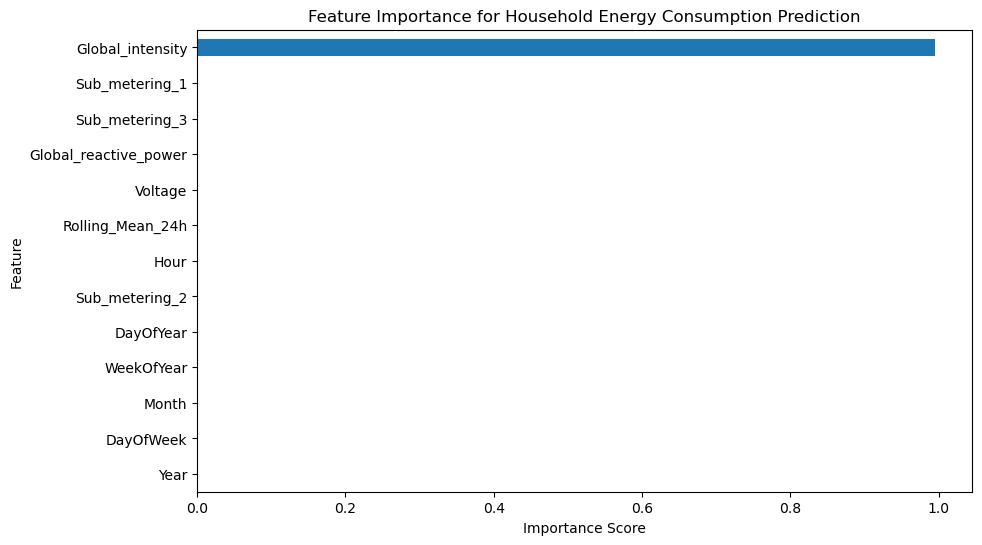

In [59]:
import matplotlib.pyplot as plt

# The best-performing model is the XGBoost model
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train_subset.columns)

#Sortinf the features by importance
sorted_features = feature_importances.sort_values(ascending=False)

print(" Key Factors Influencing Energy Usage (Feature Importance)")
print("Top 5 Most Important Features:")
print(sorted_features.head(5))

plt.figure(figsize=(10, 6))
sorted_features.plot(kind='barh')
plt.title('Feature Importance for Household Energy Consumption Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display highest importance at the top
plt.show()

top_features_list = sorted_features.index.tolist()

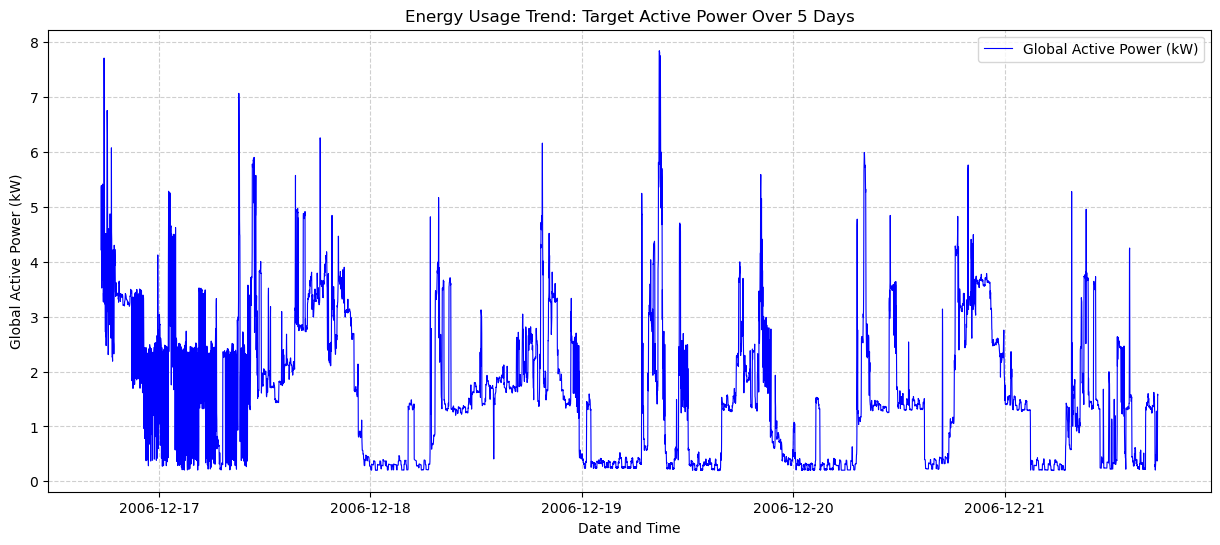

In [61]:
#First 5 days of data for the plot
start_date = data.index.min()
end_date = start_date + pd.Timedelta(days=5)

# Slicing the data for the selected period
plot_data = data.loc[start_date:end_date]

plt.figure(figsize=(15, 6))
plt.plot(plot_data['Target_Active_Power'], label='Global Active Power (kW)', color='blue', linewidth=0.8)
plt.title('Energy Usage Trend: Target Active Power Over 5 Days')
plt.xlabel('Date and Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

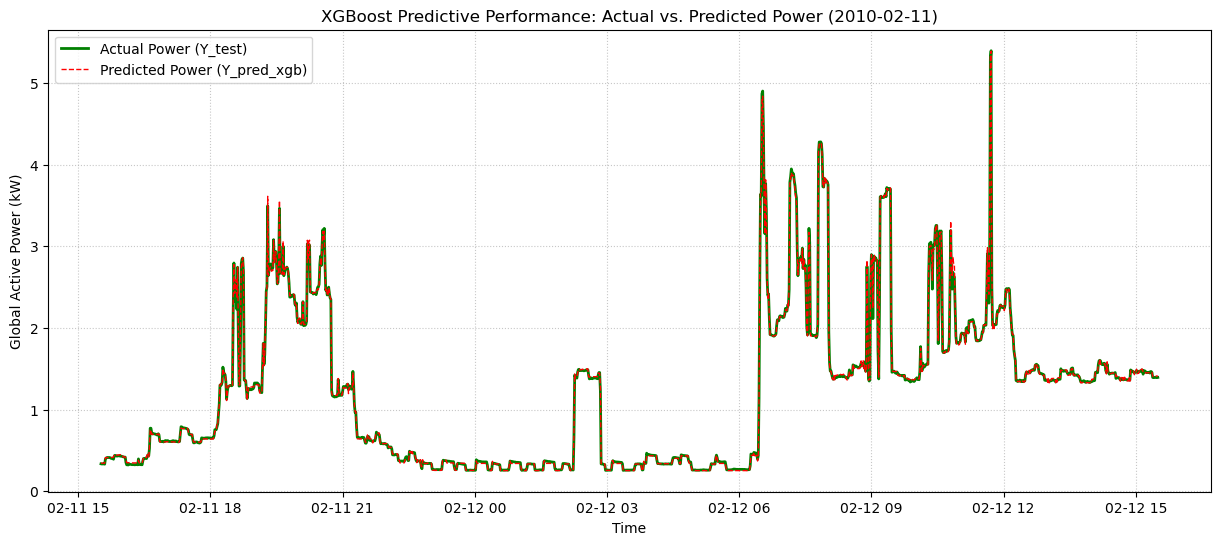

In [63]:
#The first 1440 observations (24 hours * 60 minutes/hour = 1440)
time_window = 1440 
index_slice = Y_test.index[:time_window]

actual_values = Y_test[:time_window]

# Extracting the predicted values for the window and Y_pred_xgb is a numpy array, so slicing it directly using its index
predicted_values = Y_pred_xgb[:time_window]

plt.figure(figsize=(15, 6))
plt.plot(index_slice, actual_values, label='Actual Power (Y_test)', color='green', linewidth=2)
plt.plot(index_slice, predicted_values, label='Predicted Power (Y_pred_xgb)', color='red', linestyle='--', linewidth=1)
plt.title(f'XGBoost Predictive Performance: Actual vs. Predicted Power ({pd.to_datetime(index_slice.min()).strftime("%Y-%m-%d")})')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()